# Statistical analysis of SC-FC coupling values

In [300]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols, glm
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import os

# Get the current working directory
wd = os.getcwd()
wd = (wd[:-10]+'/')

#### ADJUST#####
analysis = 'whole' 
files = 'fbc_fc'
folder = '216'
path = wd
lebs = '/data/atlas_labels.csv'
cov_hc = '/data/2-1_new'
#############

#load coupling results for both groups and the labels for the regions
hc = pd.read_csv(path+folder+'/results/'+files+'/'+analysis+'/hc_'+files+'.csv')
bd = pd.read_csv(path+folder+'/results/'+files+'/'+analysis+'/bd_'+files+'.csv')
leb = pd.read_csv(path+folder+lebs,header=None)
leb.rename(columns={leb.columns[0]: 'regions'}, inplace=True)
leb['regions'] = leb['regions'].str.replace(' ', '', regex=True)
#load covariates and PGS files
hc_cov = pd.read_csv(path+folder+cov_hc+'_HC_covar.csv')
bd_cov = pd.read_csv(path+folder+'/data/BD_covar.csv')
hc_pgs= pd.read_csv(path+folder+cov_hc+'_HC_pgs.csv')
bd_pgs = pd.read_csv(path+folder+'/data/BD_pgs.csv')

# Match r2 values shape to covariates shape and set region labels as column names
hc = hc.T 
bd = bd.T
hc.columns = leb['regions'].tolist()
bd.columns = leb['regions'].tolist()

#assign group 
hc_cov['gr'] = 0
bd_cov['gr'] = 1

# convert categorical covariates to dummies and set as categorical
hc_cov['sex'] = hc_cov['sex'].replace({'Male': 0, 'Female': 1}).astype('category')
hc_cov['centre'] = hc_cov['centre'].replace({'Cheadle (imaging)': 0, 'Newcastle (imaging)': 1, 
                                             'Reading (imaging)':2, 'Bristol (imaging)':3}).astype('category')
bd_cov['sex'] = bd_cov['sex'].replace({'Male': 0, 'Female': 1}).astype('category')
bd_cov['centre'] = bd_cov['centre'].replace({'Cheadle (imaging)': 0, 'Newcastle (imaging)': 1, 
                                             'Reading (imaging)':2, 'Bristol (imaging)':3}).astype('category')

hc_cov['gr'] = hc_cov['gr'].astype('category')
bd_cov['gr'] = bd_cov['gr'].astype('category')

# Match index type for concatenation and concatenate data with covariates
hc.index = hc.index.astype('int64')
bd.index = bd.index.astype('int64')
hc_cov.index = hc_cov.index.astype('int64')
bd_cov.index = bd_cov.index.astype('int64')
hc_pgs.index = hc_pgs.index.astype('int64')
bd_pgs.index = bd_pgs.index.astype('int64')
hc_pgs=hc_pgs.drop(['eid','ePGS'], axis=1) # remove overlapping eid column and the enhanced PGS as mostly Nans
bd_pgs=bd_pgs.drop(['eid','ePGS'], axis=1)
hc_f= pd.concat([hc_cov, hc], axis=1)
bd_f= pd.concat([bd_cov, bd], axis=1)
hc_f.set_index('eid', inplace=True)
bd_f.set_index('eid', inplace=True) # now for each group hc_f/bd_f is the full data of coupling and covariates

hc_fpgs= pd.concat([hc_cov, hc_pgs, hc], axis=1)
bd_fpgs= pd.concat([bd_cov, bd_pgs, bd], axis=1)
hc_fpgs.set_index('eid', inplace=True)
bd_fpgs.set_index('eid', inplace=True)# now for each group hc_fpgs/bd_fpgs is the full data of coupling and covariates

# concatinate both groups for full datasets to be used in GLM
data = pd.concat([bd_f, hc_f], axis=0)
data_pgs = pd.concat([bd_fpgs, hc_fpgs], axis=0)   

# make sure all categorical covariates are type categorical
data['sex'] = data['sex'].astype('category')
data['centre'] = data['centre'].astype('category')
data['gr'] = data['gr'].astype('category')
data_pgs['sex'] = data_pgs['sex'].astype('category')
data_pgs['centre'] = data_pgs['centre'].astype('category')
data_pgs['gr'] = data_pgs['gr'].astype('category')
#data_pgs = data_pgs.drop(['gr'], axis=1)

raw_data = data.iloc[:,4:]# This is the coupling for both groups without covariates

if analysis == 'cortical':
    if leb.shape[0] < 220:
        raw_data = raw_data.iloc[:,:-16]
        leb = leb.iloc[:-16]
    else:
        raw_data = raw_data.iloc[:,:-54]
        leb = leb.iloc[:-54]

/tmp/ipykernel_16466/660350805.py:46: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipykernel_16466/660350805.py:47: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipykernel_16466/660350805.py:49: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipykernel_16466/660350805.py:50: FutureWarning:

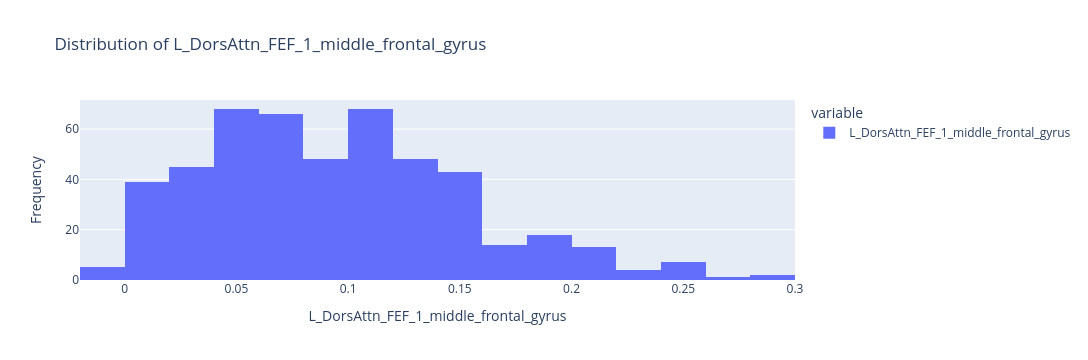

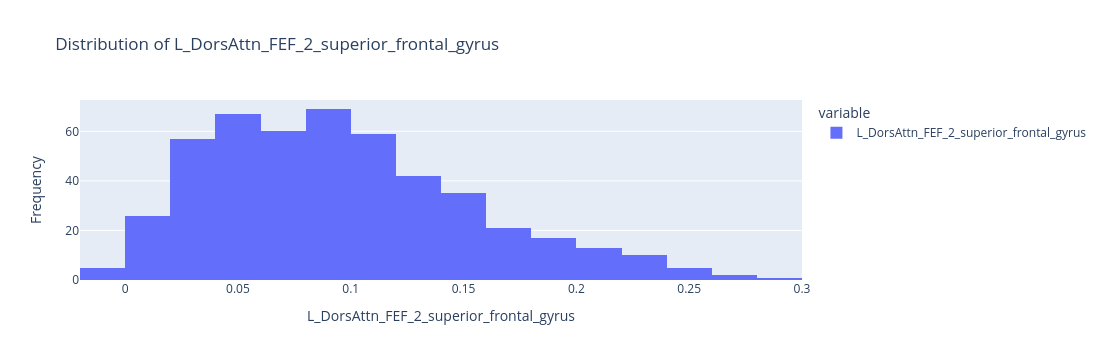

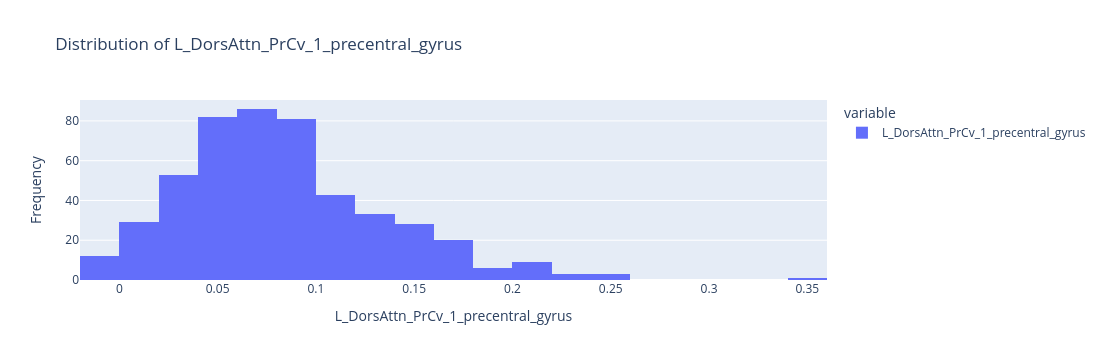

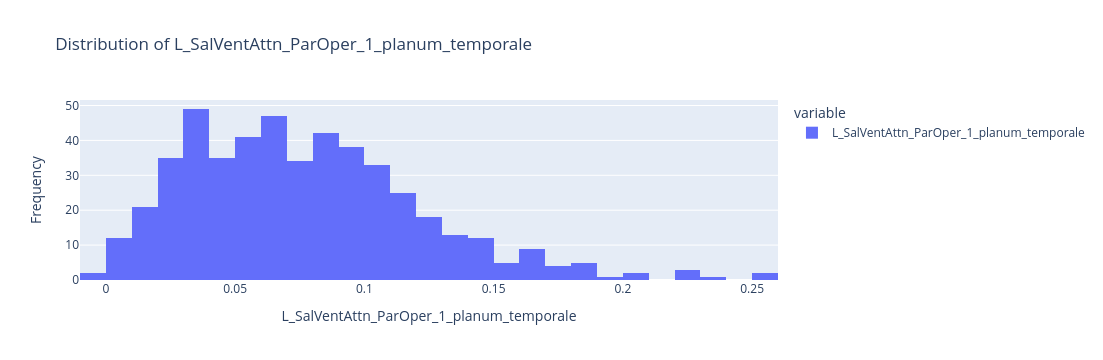

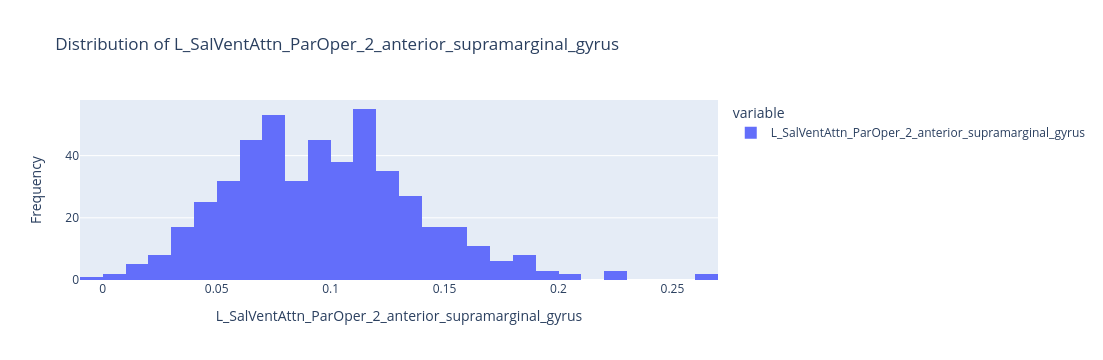

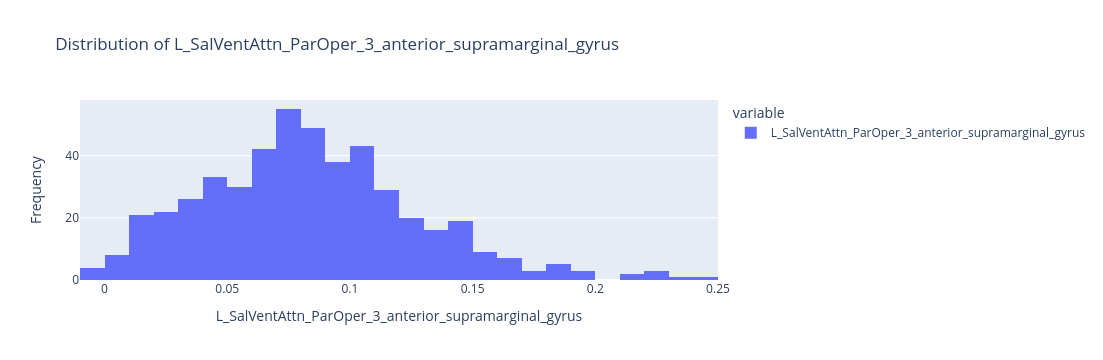

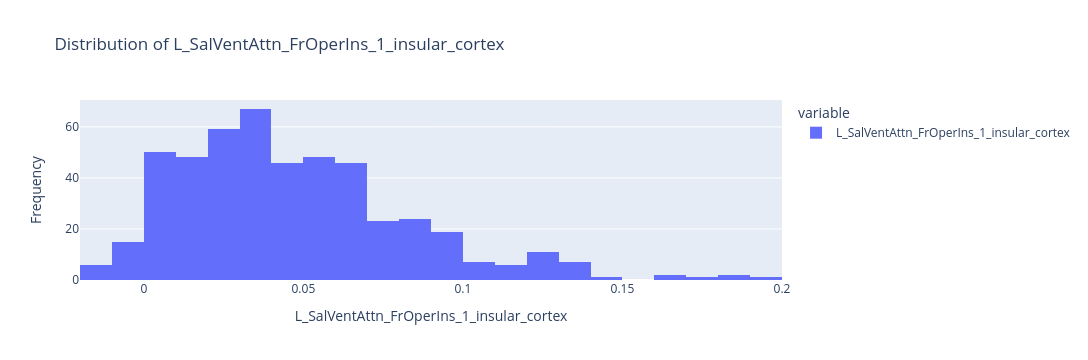

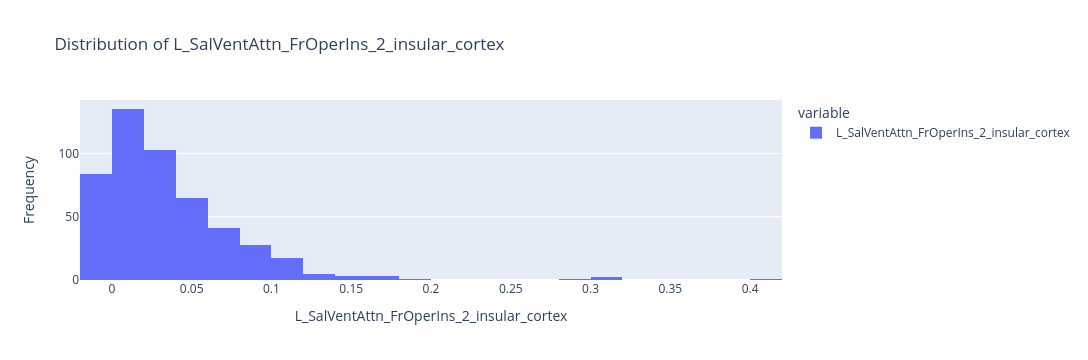

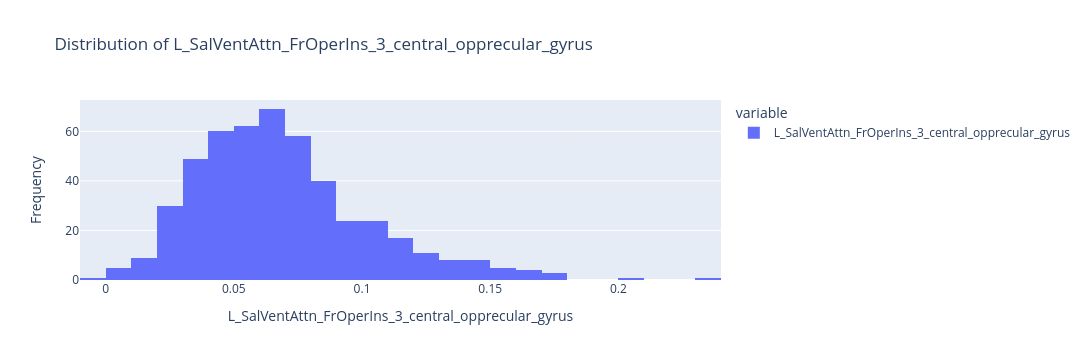

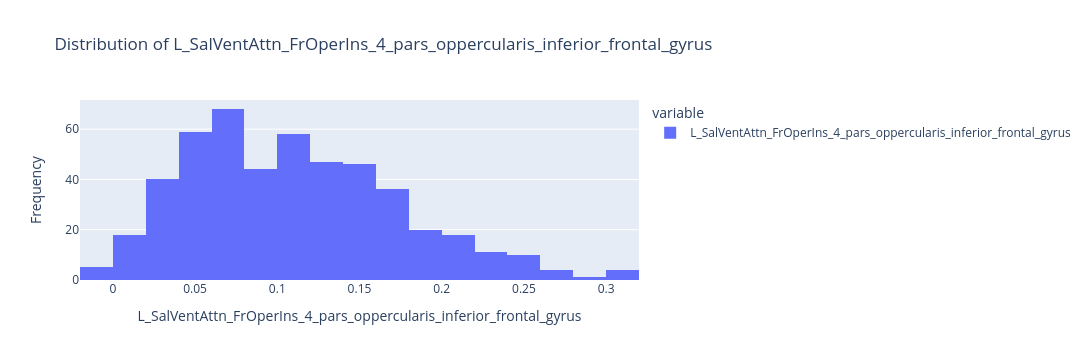

In [307]:
import plotly.express as px
import pandas as pd

# Ensure columns are numeric, convert non-numeric data to NaN
for col in raw_data.columns[40:50]:
    # Try to convert column to numeric, forcing errors to NaN
    data[col] = pd.to_numeric(data[col], errors='coerce')

    # Drop rows with NaN values in the column
    data_clean = data[col].dropna()

    # Plot using Plotly
    if not data_clean.empty:
        fig = px.histogram(data_clean, nbins=30, title=f'Distribution of {col}', labels={'value': col})
        fig.update_layout(xaxis_title=col, yaxis_title='Frequency')
        fig.show()
    else:
        print(f"Column {col} is empty or non-numeric after conversion.")

Demographics

In [228]:
# count the female and male in each group and age data
counts = hc_cov['sex'].value_counts()
print('HC females', counts[1], 'males', counts[0])
counts = bd_cov['sex'].value_counts()
print('BD females', counts[1], 'males', counts[0],'\n')
print('Mean age: HC' , round(hc_cov['age'].mean(),1), 'BD' , round(bd_cov['age'].mean(),1))
print('SD age: HC' , round(hc_cov['age'].std(),1), 'BD' , round(bd_cov['age'].std(),1))
print('Min age: HC' , hc_cov['age'].min(), 'BD' , bd_cov['age'].min())
print('Max age: HC' , hc_cov['age'].max(), 'BD' , bd_cov['age'].max())

HC females 172 males 154
BD females 86 males 77 

Mean age: HC 62.3 BD 62.3
SD age: HC 7.1 BD 7.1
Min age: HC 48.0 BD 48.0
Max age: HC 79.0 BD 79.0


# Individual level SC-FC coupling

In [229]:
raw_data.describe().loc[['max'],:].round(4).sort_values(by='max', axis=1, ascending=False).iloc[:,:20]

,L_Limbic_TempPole_3_temporal_pole,L_Limbic_OFC_1_frontal_orbital_cortex,R_Limbic_TempPole_1_temporal_pole,L_Default_PFC_2_paracingulate_gyrus,L_Vis_7_occipital_pole,R_Vis_6_occipital_pole,R_Vis_9_intracalcarine_cortex,R_Vis_12_occipital_pole,R_Vis_13_cuneal_cortex,R_Vis_14_superior_lateral_occipital_cortex,L_Vis_10_intracalcarine_cortex,L_Default_PFC_6_anterior_cingulate_gyrus,L_Vis_13_cuneal_cortex,L_Vis_12_cuneal_cortex,R_Vis_8_occipital_pole,L_Vis_9_occipital_pole,R_Default_PFCdPFCm_2_anterior_cingulate_gyrus,R_Vis_10_intracalcarine_cortex,L_Vis_4_lingual_gyrus,R_Vis_4_lingual_gyrus
max,1.0,1.0,1.0,0.5814,0.5757,0.5666,0.5604,0.5483,0.5426,0.5368,0.5264,0.5226,0.5207,0.5192,0.5064,0.506,0.5045,0.4997,0.488,0.4829


2 participants had regions with empty values across all timepoints in their timeseries. Could replace with mean R2 or replace with mean regional activity at the timeseries stage. for now replace with R2

In [230]:
clean_data = raw_data.copy()

def replace_ones_with_mean(data):
    if isinstance(data, pd.DataFrame):
        for column in data.columns:
            if 1 in data[column].values:  # Check if 1 is in the column
                column_mean = data[column][data[column] != 1].mean()  # Calculate mean excluding 1
                data[column] = data[column].replace(1, column_mean)   # Replace 1 with the mean
                print(f"Column '{column}' had 1 replaced with mean")
    
    elif isinstance(data, pd.Series):
        if 1 in data.values:  # Check if 1 is in the Series
            series_mean = data[data != 1].mean()  # Calculate mean excluding 1
            data = data.replace(1, series_mean)   # Replace 1 with the mean
            print(f"Series had 1 replaced with mean")
    return data  # Return the modified Series

clean_data=replace_ones_with_mean(clean_data)

Column 'L_Limbic_OFC_1_frontal_orbital_cortex' had 1 replaced with mean
Column 'L_Limbic_TempPole_3_temporal_pole' had 1 replaced with mean
Column 'R_Limbic_TempPole_1_temporal_pole' had 1 replaced with mean


In [231]:
print("\nHighest coupled by individual values:\n",
      clean_data.describe().loc[['max'],:].round(4).sort_values(by='max', axis=1, ascending=False).iloc[:,:8],"\n")

print("\nLowest coupled by individual values:\n",
      clean_data.describe().loc[['min'],:].round(4).sort_values(by='min', axis=1, ascending=True).iloc[:,:8])


Highest coupled by individual values:
      L_Default_PFC_2_paracingulate_gyrus  L_Vis_7_occipital_pole  \
max                               0.5814                  0.5757   

     R_Vis_6_occipital_pole  R_Vis_9_intracalcarine_cortex  \
max                  0.5666                         0.5604   

     R_Vis_12_occipital_pole  R_Vis_13_cuneal_cortex  \
max                   0.5483                  0.5426   

     R_Vis_14_superior_lateral_occipital_cortex  \
max                                      0.5368   

     L_Vis_10_intracalcarine_cortex  
max                          0.5264   


Lowest coupled by individual values:
      R_posterior_thalamus  R_amygdala  R_pallidum  L_accumbens  \
min               -0.0188     -0.0187     -0.0187      -0.0186   

     R_SalVentAttn_FrOperIns_1_insular_cortex  \
min                                   -0.0183   

     L_SalVentAttn_FrOperIns_4_pars_oppercularis_inferior_frontal_gyrus  \
min                                            -0.0182    

In [232]:
clean_data.describe()

,L_Vis_1_lingual_gyrus,L_Vis_2_occipital_fusiform_gyrus,L_Vis_3_lateral_inferior_occipital_cortex,L_Vis_4_lingual_gyrus,L_Vis_5_occipital_pole,L_Vis_6_lingual_gyrus,L_Vis_7_occipital_pole,L_Vis_8_lateral_inferior_occipital_cortex,L_Vis_9_occipital_pole,L_Vis_10_intracalcarine_cortex,...,R_putamen,R_caudate,L_hippocampus,L_amygdala,L_posterior_thalamus,L_anterior_thalamus,L_accumbens,L_pallidum,L_putamen,L_caudate
count,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,...,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000
mean,0.134206,0.210230,0.132935,0.231216,0.184873,0.121083,0.258429,0.116204,0.267046,0.234911,...,0.046403,0.083094,0.035663,0.059701,0.034038,0.043301,0.084070,0.059557,0.056310,0.104153
std,0.072765,0.085534,0.060293,0.097679,0.106116,0.073732,0.120529,0.058493,0.095001,0.109194,...,0.051245,0.074602,0.038168,0.053942,0.038557,0.040918,0.081261,0.055943,0.057171,0.080910
min,-0.005506,-0.008995,0.005923,0.003997,-0.013147,-0.012290,-0.007502,-0.011428,0.012034,-0.000897,...,-0.017176,-0.017014,-0.017533,-0.011546,-0.017626,-0.016150,-0.018574,-0.017824,-0.016264,-0.013789
25%,0.078455,0.144934,0.089305,0.156777,0.103713,0.066212,0.170884,0.071428,0.199901,0.154502,...,0.010048,0.027750,0.006667,0.020630,0.005315,0.012407,0.024782,0.020396,0.013490,0.045836
50%,0.128975,0.208619,0.128782,0.231024,0.171819,0.114017,0.259312,0.111710,0.263154,0.242985,...,0.031207,0.065115,0.027933,0.045122,0.024658,0.035829,0.060521,0.046445,0.040116,0.084679
75%,0.180725,0.267826,0.171552,0.298167,0.258129,0.162018,0.341817,0.153402,0.342219,0.306874,...,0.069710,0.117002,0.055620,0.087519,0.053469,0.062641,0.121395,0.086681,0.084570,0.149880
max,0.446278,0.428206,0.375491,0.487974,0.477168,0.411935,0.575689,0.328918,0.506044,0.526439,...,0.362487,0.416735,0.183610,0.331133,0.231002,0.240737,0.422087,0.339872,0.288761,0.428562


## Regional SC-FC means (averaged)

In [233]:
# Create indexing per hemisphere for the plots based on the length of the data
if leb.shape[0] < 220:
    left = slice(None, 100)
    right = slice(100, 200)
    subr = slice(200, 208)
    subl = slice(208, None)
else:
    left = slice(None, 250)
    right = slice(250, 500)
    subr = slice(500, 527)
    subl = slice(527, None)
    
# calculate the mean coupling for each region across participants
hc_mean = hc.mean()
bd_mean = bd.mean()
data_mean = clean_data.mean()
data_sd = clean_data.std()
data_min = clean_data.min()
data_max = clean_data.max()

# get the stats of the regional means
data_stats = pd.DataFrame({'mean': data_mean, 'sd': data_sd, 'min': data_min, 'max': data_max})
data_mean_max = data_stats.sort_values(by='mean', ascending=False)
data_mean_min = data_stats.sort_values(by='mean', ascending=True)
print('Highest coupled regions averaged across participants:')
data_mean_max.round(4).head(4)

Highest coupled regions averaged across participants:


,mean,sd,min,max
R_Vis_12_occipital_pole,0.2959,0.1014,-0.0011,0.5483
R_Vis_13_cuneal_cortex,0.2783,0.1072,0.0223,0.5426
L_Vis_13_cuneal_cortex,0.2735,0.1004,-0.0083,0.5207
L_Vis_9_occipital_pole,0.2670,0.0950,0.0120,0.5060


In [234]:
print('Lowest coupled regions averaged across participants:')
data_mean_min.round(4).head(5)

Lowest coupled regions averaged across participants:


,mean,sd,min,max
R_hippocampus,0.0324,0.0378,-0.0166,0.2261
L_posterior_thalamus,0.0340,0.0386,-0.0176,0.2310
L_SalVentAttn_FrOperIns_2_insular_cortex,0.0353,0.0455,-0.0171,0.4019
L_hippocampus,0.0357,0.0382,-0.0175,0.1836
R_posterior_thalamus,0.0358,0.0394,-0.0188,0.2420


Plot the regions for each hemisphere

In [235]:
# initiate colors
c1='coral'
c2='teal'

# loop over the networks to assign them color for the bar plot
for ix, s in enumerate(leb['regions']):    
    if 'Vis' in s:
        leb.loc[ix,'networks']= 'Visual'
        leb.loc[ix,'colors']= c1
    elif 'Som' in s:
        leb.loc[ix,'networks']= 'SMN'
        leb.loc[ix,'colors']= c2
    elif 'Dor' in s:
        leb.loc[ix,'networks']= 'DAN'
        leb.loc[ix,'colors']= c1
    elif 'Sal' in s:
        leb.loc[ix,'networks']= 'VAN'
        leb.loc[ix,'colors']= c2       
    elif 'Lim' in s:
        leb.loc[ix,'networks']= 'Limbic'
        leb.loc[ix,'colors']= c1
    elif 'Cont' in s:
        leb.loc[ix,'networks']= 'ECN'
        leb.loc[ix,'colors']= c2
    elif 'Def' in s:
        leb.loc[ix,'networks']= 'DMN'
        leb.loc[ix,'colors']=c1 
    else:
        leb.loc[ix,'networks']= 'Subcortex'
        leb.loc[ix,'colors']= c2

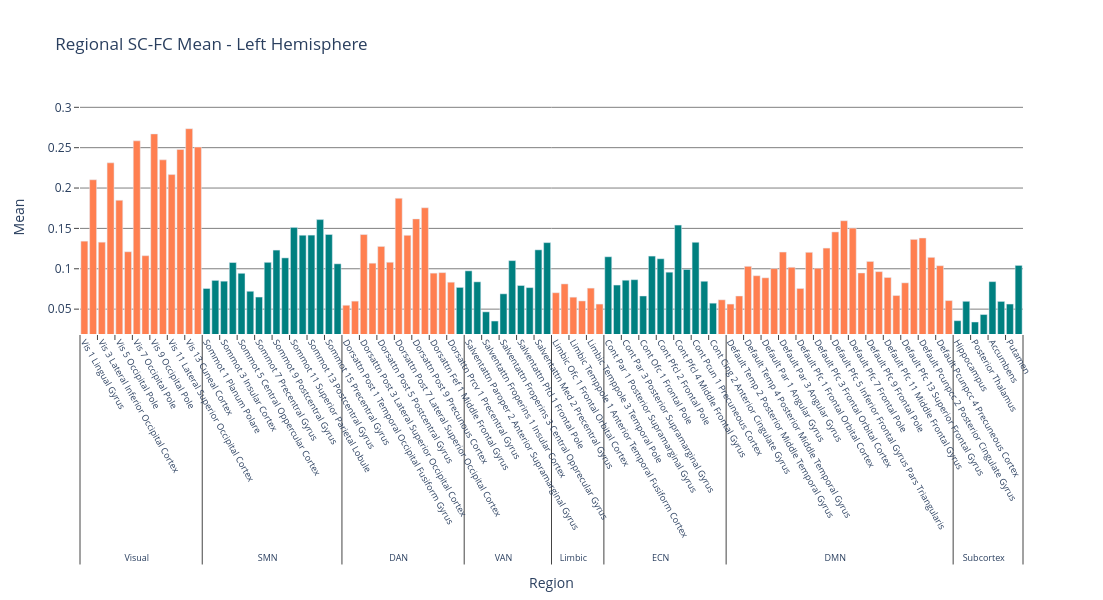

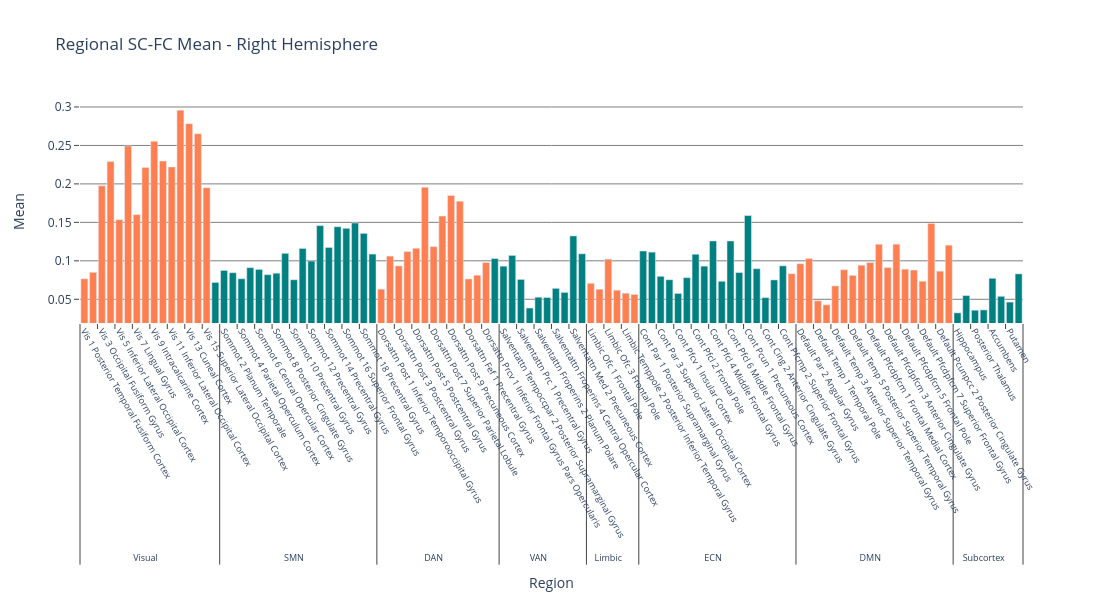

In [236]:
import plotly.graph_objs as go

leb['plot'] = leb['regions'].str.replace('L_', '', regex=True)
leb['plot'] = leb['plot'].str.replace('R_', '', regex=True)
leb['plot'] = leb['plot'].str.replace('_', ' ', regex=True)
leb['plot'] = leb['plot'].str.title()

#set y range so all plots will be on the same y limits
y_min = data_mean.values.min()
y_max = data_mean.values.max()
y_margin = (y_max - y_min) * 0.05
y_range = [y_min - y_margin, y_max + y_margin]

####### LEFT HEMISPHERE ####
x_inner = leb['plot'].iloc[left].tolist()+ leb['plot'].iloc[subl].tolist()
x_outer = leb['networks'].iloc[left].tolist() +leb['networks'].iloc[subl].tolist()
cc = leb['colors'].iloc[left].tolist() +leb['colors'].iloc[subl].tolist()
x = [x_outer,x_inner]
bar_trace = go.Bar(
    x=x,  
    y=data_mean.iloc[left].tolist()+data_mean.iloc[subl].tolist(),
    orientation='v',
    name='Mean',
    marker_color=cc)

layout = go.Layout(
    title='Regional SC-FC Mean - Left Hemisphere',
    xaxis=dict(
        title='Region',
        type='multicategory',
        tickangle=60,
        automargin=True,
        mirror=True,
        ticks='outside',
        showline=False,
        linecolor='dimgray',
        linewidth=0.2,
        tickfont=dict(size=9),
    ),
    yaxis=dict(title='Mean', range=y_range, 
        showgrid=True,
        mirror=True,
        ticks='outside',
        showline=False,
        linecolor='dimgray',
        dtick=0.05,
        gridcolor='grey'               
),  
    width=1100,
    height=600,    
    plot_bgcolor='white',  # Set plot background color to white
    paper_bgcolor='white'
)
fig = go.Figure(data=[bar_trace], layout=layout)
fig.show()


####### RIGHT HEMISPHERE ####
x_inner = leb['plot'].iloc[right].tolist()+ leb['plot'].iloc[subr].tolist()
x_outer = leb['networks'].iloc[right].tolist() +leb['networks'].iloc[subr].tolist()
cc = leb['colors'].iloc[right].tolist() +leb['colors'].iloc[subr].tolist()
x = [x_outer,x_inner]
bar_trace = go.Bar(
    x=x,  
    y=data_mean.iloc[right].tolist()+data_mean.iloc[subr].tolist(),
    orientation='v',
    name='Mean',
    marker_color=cc)

layout = go.Layout(
    title='Regional SC-FC Mean - Right Hemisphere',
    xaxis=dict(
        title='Region',
        type='multicategory',
        tickangle=60,
        automargin=True,
        mirror=True,
        ticks='outside',
        showline=False,
        linecolor='dimgray',
        linewidth=0.2,
        tickfont=dict(size=9),
    ),
    yaxis=dict(title='Mean', range=y_range, 
        showgrid=True,
        mirror=True,
        ticks='outside',
        showline=False,
        linecolor='dimgray',
        dtick=0.05,
        gridcolor='grey'               
),  
    width=1100,
    height=600,    
    plot_bgcolor='white',  # Set plot background color to white
    paper_bgcolor='white'
)
fig = go.Figure(data=[bar_trace], layout=layout)
fig.show()

brain plot of the regional SC-FC coupling values

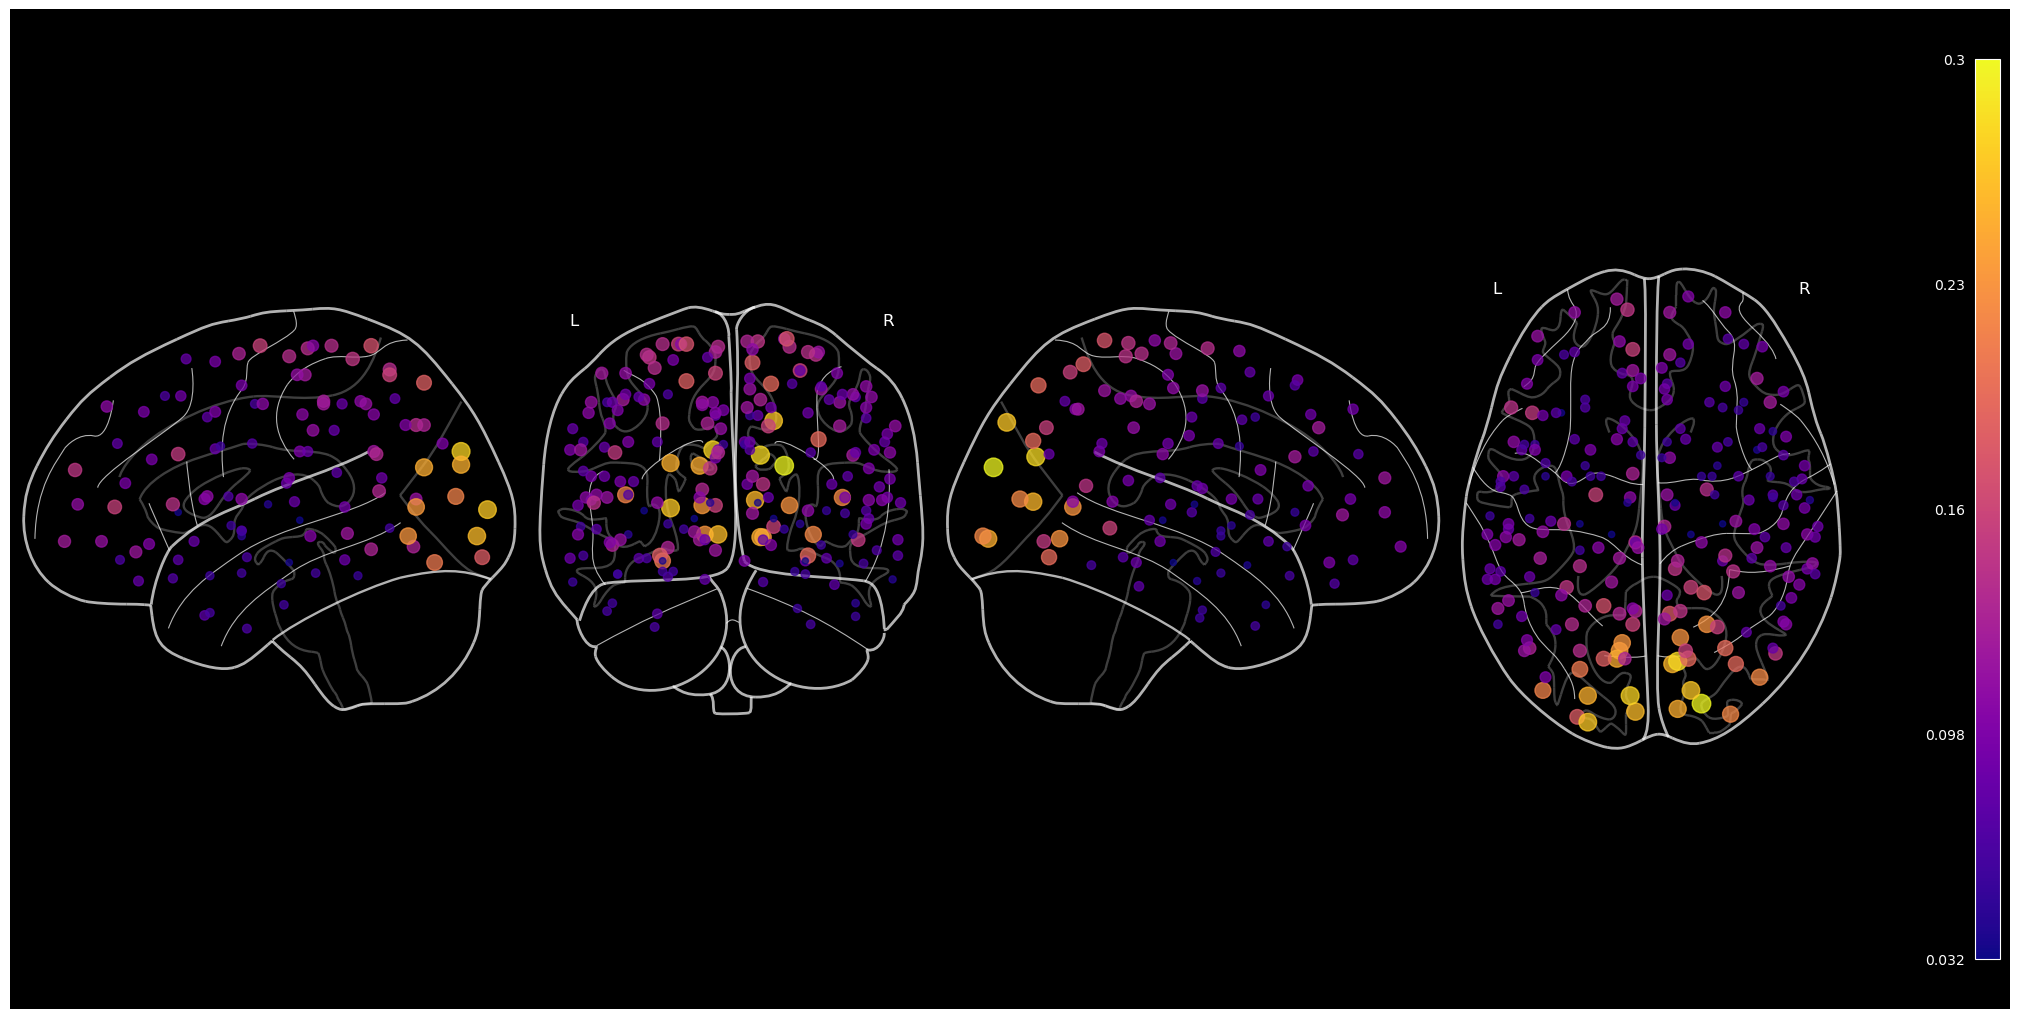

In [237]:
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.datasets import load_mni152_template
import matplotlib.cm as cm
from cmap import Colormap
import urllib.request

if leb.shape[0] < 220:
    cortical = '200'
    subcortical = '1'
else:
    cortical = '500'
    subcortical = '4'    

# Fetch the Schaefer parcellation data from the URL
url = 'https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_'+cortical+'Parcels_7Networks_order_FSLMNI152_1mm.Centroid_RAS.csv'
response = urllib.request.urlopen(url)
sch = np.genfromtxt(response, delimiter=',')
sch = sch[1:]
sch = sch[:, 2:]

# Load the Tian subcortex data from the file (unless analysis scope was cortical)
if analysis != 'cortical':
    file_path = '/home/shir/Documents/connectomics/atlases/Tian_Subcortex_S'+subcortical+'_3T_COG.txt'
    tia = np.loadtxt(file_path)
    coords = np.vstack((sch, tia))
    
else:
    coords=sch

# coupling values to plot
values = data_mean.to_numpy()
# Create a custom colormap
cmap = Colormap('plasma').to_matplotlib() #using the pretty cmap package colormaps and converting to plt for the colorbar to work

#colorcet:CET_CBTD1
#chrisluts:BOP_Blue

if analysis == 'whole':
    if files == 'fbc_fc':
        scale=600
    else:
        scale=600
elif analysis == 'between':
    if files == 'fbc_fc':
        scale=100
    else:
        scale=900
elif analysis == 'within':
    if files == 'fbc_fc':
        scale=40
    else:
        scale=60

# Create the plot using nilearn's plot_markers
fig = plt.figure(figsize=(20, 10))
display = plotting.plot_markers(node_values=values, node_coords=coords, node_cmap=cmap, node_size=abs(600*values), alpha=0.75, 
                                display_mode='lyrz', black_bg=True, figure=fig, colorbar=True)

# Modify the background color of the figure
#fig.patch.set_facecolor('dimgrey')

#plt.savefig(f'{leb.shape[0]}_{analysis}_{files}.svg', dpi=300)
plt.show()

import matplotlib.colors as mcolors
from nilearn.datasets import fetch_surf_fsaverage

# Normalize the values to be between 0 and 1
norm = mcolors.Normalize(vmin=np.min(values), vmax=np.max(values))
normalized_values = norm(values)

# Map the normalized values to colors using the colormap
colors = cmap(normalized_values)

# Convert RGBA colors to hex
colors_hex = [mcolors.to_hex(c) for c in colors]

# Fetch the fsaverage dataset for plotting
fsaverage = fetch_surf_fsaverage()
view = plotting.view_markers(coords, colors_hex, marker_size=8)#marker_labels=list(data_mean.index), title = 'Regional SC-FC Coupling')#marker_labels=list(data_mean.index)

# Display the plot in an interactive window
#view.open_in_browser()


In [238]:
#store labels with coords for later plotting
label_coord = {}
for l ,c in zip(leb['regions'], coords):
    label_coord[l] = c

## Means by network

In [239]:
# lists to store the indices of each network
vis = [] 
smn = []
dan = []
van = []
lim = []
dmn = []
ecn = []
sub = []

# loop to extract the ondices of each network
for ix, s in enumerate(leb['regions']):
    if 'Vis' in s:
        vis.append(ix)
    elif 'Som' in s:
        smn.append(ix)
    elif 'Dor' in s:
        dan.append(ix)
    elif 'Sal' in s:
        van.append(ix)
    elif 'Lim' in s:
        lim.append(ix)
    elif 'Cont' in s:
        ecn.append(ix)
    elif 'Def' in s:
        dmn.append(ix)
    else:
        sub.append(ix)

# loop to print the means of each network in both groups and in total
groups = [hc_mean, bd_mean, data_mean]
group_names = ['HC', 'BD', 'Both']
means = []
stds = []

for group, name in zip(groups, group_names):
    print(f"{name}:")
    visual = group.iloc[vis]
    somatomotor = group.iloc[smn]
    dor_at = group.iloc[dan]
    sal = group.iloc[van]
    limbic = group.iloc[lim]
    ecnn = group.iloc[ecn]
    dmnn = group.iloc[dmn]
    subb = group.iloc[sub]
    
    print(f"Visual mean: {visual.mean():.5f}, std: {visual.std():.5f}, max: {visual.max():.3f}, min: {visual.min():.3f}")
    print(f"Somatomotor mean: {somatomotor.mean():.5f}, std: {somatomotor.std():.5f}, max: {somatomotor.max():.3f}, min: {somatomotor.min():.3f}")
    print(f"Dorsal Attention: {dor_at.mean():.5f}, std: {dor_at.std():.5f}, max: {dor_at.max():.3f}, min: {dor_at.min():.3f}")
    print(f"Ventral Attention: {sal.mean():.5f}, std: {sal.std():.5f}, max: {sal.max():.3f}, min: {sal.min():.3f}")
    print(f"Limbic mean: {limbic.mean():.5f}, std: {limbic.std():.5f}, max: {limbic.max():.3f}, min: {limbic.min():.3f}")
    print(f"ECN mean: {ecnn.mean():.5f}, std: {ecnn.std():.5f}, max: {ecnn.max():.3f}, min: {ecnn.min():.3f}")
    print(f"DMN mean: {dmnn.mean():.5f}, std: {dmnn.std():.5f}, max: {dmnn.max():.3f}, min: {dmnn.min():.3f}")
    print(f"Subcortex mean: {subb.mean():.5f}, std: {subb.std():.5f}, max: {subb.max():.3f}, min: {subb.min():.3f} \n")

HC:
Visual mean: 0.20942, std: 0.06036, max: 0.301, min: 0.080
Somatomotor mean: 0.10829, std: 0.02727, max: 0.159, min: 0.063
Dorsal Attention: 0.11873, std: 0.04210, max: 0.193, min: 0.054
Ventral Attention: 0.08289, std: 0.02825, max: 0.130, min: 0.037
Limbic mean: 0.06834, std: 0.01315, max: 0.102, min: 0.055
ECN mean: 0.09619, std: 0.02666, max: 0.161, min: 0.052
DMN mean: 0.09795, std: 0.02814, max: 0.161, min: 0.043
Subcortex mean: 0.05618, std: 0.02155, max: 0.106, min: 0.032 

BD:
Visual mean: 0.20121, std: 0.06020, max: 0.286, min: 0.070
Somatomotor mean: 0.10780, std: 0.02973, max: 0.164, min: 0.065
Dorsal Attention: 0.12262, std: 0.04194, max: 0.200, min: 0.056
Ventral Attention: 0.08216, std: 0.03154, max: 0.142, min: 0.033
Limbic mean: 0.07004, std: 0.01514, max: 0.103, min: 0.055
ECN mean: 0.09574, std: 0.02706, max: 0.156, min: 0.054
DMN mean: 0.09777, std: 0.02624, max: 0.157, min: 0.043
Subcortex mean: 0.05576, std: 0.02127, max: 0.101, min: 0.032 

Both:
Visual mean:

## ANCOVA for region level

Perform a GLM with a Gamma family function and log link function (R2 vdisribution is pretty right sqewed):

In [294]:
import statsmodels.api as sm
from statsmodels.genmod import families
from statsmodels.genmod.families import links
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests

model_summaries = []  # store model summaries
group_p_values = []  # store p-values for 'group'
group_z_values = []  # store F-values for 'group'
group_coefficients = []  # store coefficients for 'group'

age_p_values = []  # store p-values for 'group'
age_z_values = []  # store F-values for 'group'
age_coefficients = []  # store coefficients for 'group'

# Perform GLM for each outcome variable column separately
for col in data.columns[4:]:  # outcome variable columns start from index 4
    # Remove outliers for the current column
    y = data[col].copy()  # store the outcome variable
    ys = replace_ones_with_mean(y)  # for error measurements (often in limbic net)  

    #for Gamma with log, values should be positive to not encounter erros:
    min_value = ys.min() 
    shift_amount = abs(min_value) + 1e-10
    ys = ys + shift_amount #shift all data points so all are positive
    
    temp_data = pd.concat([ys, data[['gr', 'age', 'sex', 'centre']]], axis=1) #concat each time a new y with the IVs
    temp_data.columns = [col, 'gr', 'age', 'sex', 'centre'] # name the columns

    # Perform GLM
    formula = f'{col} ~ C(gr) + age + C(sex) + C(centre)'  # GLM formula
    model = sm.GLM.from_formula(formula, data=temp_data, family=families.Gamma(link=links.Log())).fit()
    
    # Store GLM summary
    summary = model.summary2().tables[1]  # extract the summary table
    model_summaries.append(summary)  # add the summary table to the list
    
    # Extract p-value and z-value for 'group'
    group_p_values.append(summary.loc['C(gr)[T.1]', 'P>|z|'])
    group_z_values.append(summary.loc['C(gr)[T.1]', 'z'])
    group_coefficients.append(summary.loc['C(gr)[T.1]', 'Coef.'])
    
    age_p_values.append(summary.loc['age', 'P>|z|'])
    age_z_values.append(summary.loc['age', 'z'])
    age_coefficients.append(summary.loc['age', 'Coef.'])

# Apply correction to the p-values for 'group'
_, gr_corrected_p_values, _, _ = multipletests(group_p_values, method='bonferroni')
gr_corrected_p_values_df = pd.DataFrame(gr_corrected_p_values, index=data.columns[4:], columns=['bonf_p-value'])
gr_z_values_df = pd.DataFrame(group_z_values, index=data.columns[4:], columns=['z-value'])
gr_p_values_df = pd.DataFrame(group_p_values, index=data.columns[4:], columns=['p-value'])
gr_coefficients_df = pd.DataFrame(group_coefficients, index=data.columns[4:], columns=['coef'])
# Concatenate F-values, FDR corrected p-values, raw p-values, and coefficients into a single DataFrame
group_result_df = pd.concat([z_values_df, gr_corrected_p_values_df, p_values_df, coefficients_df], axis=1)

main_top_hits = group_result_df[group_result_df['bonf_p-value'] <= 0.05]
group_main_top_hits = main_top_hits.sort_values(by='bonf_p-value', ascending=True)

# Apply correction to the p-values for 'group'
_, age_corrected_p_values, _, _ = multipletests(age_p_values, method='bonferroni')
age_corrected_p_values_df = pd.DataFrame(age_corrected_p_values, index=data.columns[4:], columns=['bonf_p-value'])
age_z_values_df = pd.DataFrame(age_z_values, index=data.columns[4:], columns=['z-value'])
age_p_values_df = pd.DataFrame(age_p_values, index=data.columns[4:], columns=['p-value'])
age_coefficients_df = pd.DataFrame(age_coefficients, index=data.columns[4:], columns=['coef'])
# Concatenate F-values, FDR corrected p-values, raw p-values, and coefficients into a single DataFrame
age_result_df = pd.concat([age_z_values_df, age_corrected_p_values_df, age_p_values_df, age_coefficients_df], axis=1)



#### Print summary of each model and FDR corrected p-values for 'group' ####
for idx, summary in enumerate(model_summaries):
    print(f"GLM Summary for Outcome Variable {data.columns[4:][idx]}:")
    print(summary)

# View the final results
group_main_top_hits

Series had 1 replaced with mean
Series had 1 replaced with mean
Series had 1 replaced with mean
GLM Summary for Outcome Variable L_Vis_1_lingual_gyrus:
                   Coef.  Std.Err.         z         P>|z|    [0.025    0.975]
Intercept      -1.613359  0.207991 -7.756858  8.705902e-15 -2.021015 -1.205704
C(gr)[T.1]     -0.011848  0.049885 -0.237502  8.122674e-01 -0.109622  0.085926
C(sex)[T.1]     0.125875  0.046863  2.686009  7.231118e-03  0.034025  0.217725
C(centre)[T.1] -0.081386  0.058447 -1.392480  1.637772e-01 -0.195939  0.033168
C(centre)[T.2] -0.119795  0.065925 -1.817138  6.919595e-02 -0.249007  0.009416
C(centre)[T.3] -0.617034  0.518356 -1.190367  2.339021e-01 -1.632994  0.398925
age            -0.006162  0.003294 -1.870662  6.139189e-02 -0.012618  0.000294
GLM Summary for Outcome Variable L_Vis_2_occipital_fusiform_gyrus:
                   Coef.  Std.Err.         z         P>|z|    [0.025    0.975]
Intercept      -1.021859  0.157429 -6.490907  8.532142e-11 -1.330415 -

,z-value,bonf_p-value,p-value,coef
L_Limbic_TempPole_3_temporal_pole,4.070009,0.010154,0.000047,0.280607


In [292]:
age_result_df.sort_values(by='bonf_p-value', ascending=True).head(10)

,z-value,bonf_p-value,p-value,coef
L_Default_PFC_6_anterior_cingulate_gyrus,-4.960387,0.000152,7.035288e-07,-0.015048
R_SomMot_1_heschls_gyrus,-4.557195,0.001120,5.184124e-06,-0.014695
R_Default_PFCdPFCm_2_anterior_cingulate_gyrus,-4.552422,0.001145,5.303187e-06,-0.016366
L_Default_PFC_2_paracingulate_gyrus,-4.224033,0.005183,2.399693e-05,-0.014060
R_Default_PFCdPFCm_1_frontal_medial_cortex,-4.151963,0.007120,3.296357e-05,-0.013954
L_Default_PFC_8_anterior_cingulate_gyrus,-3.694204,0.047645,2.205769e-04,-0.018474
R_Limbic_OFC_2_frontal_orbital_cortex,-3.611223,0.065827,3.047559e-04,-0.017107
R_Default_pCunPCC_1_precuneous,-3.596248,0.069734,3.228404e-04,-0.013369
L_Cont_Cing_1_posterior_cingulate_gyrus,-3.415639,0.137447,6.363266e-04,-0.012568
R_Cont_PFCmp_1_paracingulate_gyrus,-3.412803,0.138885,6.429842e-04,-0.016825


In [293]:
group_result_df.sort_values(by='p-value', ascending=True).head(4)

,z-value,bonf_p-value,p-value,coef
L_Limbic_TempPole_3_temporal_pole,4.070009,0.010154,0.000047,0.280607
R_DorsAttn_FEF_2_superior_frontal_gyrus,2.871988,0.881060,0.004079,0.150114
L_DorsAttn_Post_9_precunous_cortex,2.583758,1.000000,0.009773,0.118216
R_pallidum,-2.434017,1.000000,0.014932,-0.173131


In [242]:
scaler = StandardScaler()
model_summaries = []  # store model summaries
group_p_values = []  # store p-values for 'group'
group_f_values = []  # store F-values for 'group'
group_coefficients = []  # store coefficients for 'group'


# Perform ANCOVA for each outcome variable column separately
for col in data.columns[4:]:  # outcome variable columns start from index 4
    # Remove outliers for the current column
    y = data[col].copy() # store the outcome variable
    ys=replace_ones_with_mean(y) # for error measurements (often in limbic net)    
    yr=np.sqrt(abs(ys)) #for normality
    y_standardized = scaler.fit_transform(yr.values.reshape(-1, 1)).flatten() # for better interpertation of results
    yr = pd.Series(y_standardized, index=yr.index)
    
    temp_data = pd.concat([yr, data[['gr', 'age', 'sex', 'centre']]], axis=1)
   # temp_data.dropna(inplace=True)
    temp_data.columns = [col, 'gr', 'age', 'sex', 'centre']

    # Perform ANCOVA
    formula = f'{col} ~ C(gr) + age + C(sex) + C(centre)'  # ANCOVA formula with concatenated data
    model = ols(formula, data=temp_data).fit()
    
    # Extract residuals
    residuals = model.resid
    # Perform Shapiro-Wilk normality test on residuals
    stat, p_value = stats.shapiro(residuals)
    # Check if residuals are normally distributed
    if p_value < (0.05/leb.shape[0]):
        print(f"Residuals for '{col}' not normally distributed (p-value = {p_value:.4f})")
    
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    # Store ANOVA summary
    model_summaries.append(anova_table)
    
    # Store p-value and F-value for 'group'
    group_p_values.append(anova_table.loc['C(gr)', 'PR(>F)'])
    group_f_values.append(anova_table.loc['C(gr)', 'F'])
    
    # Store the coefficient of 'gr' to see the direction
    group_coefficients.append(model.params.filter(like='C(gr)'))

# Apply FDR correction to the p-values for 'group'
_, fdr_corrected_p_values, _, _ = multipletests(group_p_values, method='fdr_bh')
fdr_corrected_p_values_df = pd.DataFrame(fdr_corrected_p_values, index=data.columns[4:], columns=['Bonf p-value'])
f_values_df = pd.DataFrame(group_f_values, index=data.columns[4:], columns=['F-value'])
p_values_df = pd.DataFrame(group_p_values, index=data.columns[4:], columns=['p-value'])

# Combine coefficients into a DataFrame
coefficients_df = pd.DataFrame(group_coefficients, index=data.columns[4:])

# Concatenate F-values, FDR corrected p-values, raw p-values, and coefficients into a single DataFrame
result_df = pd.concat([f_values_df, fdr_corrected_p_values_df, p_values_df, coefficients_df], axis=1)

main_top_hits = result_df[result_df['Bonf p-value'] <= 0.05]

# Sort by FDR p-value
main_top_hits = main_top_hits.sort_values(by='Bonf p-value', ascending=True)

# Print summary of each model and FDR corrected p-values for 'group'
#for idx, summary in enumerate(model_summaries):
 #   print(f"ANCOVA Summary for Outcome Variable {data.columns[4:][idx]}:")
#    print(summary)

# View the final results
main_top_hits

Residuals for 'L_Vis_2_occipital_fusiform_gyrus' not normally distributed (p-value = 0.0001)
Residuals for 'L_Vis_4_lingual_gyrus' not normally distributed (p-value = 0.0000)
Residuals for 'L_Vis_5_occipital_pole' not normally distributed (p-value = 0.0000)
Residuals for 'L_Vis_7_occipital_pole' not normally distributed (p-value = 0.0000)
Residuals for 'L_Vis_9_occipital_pole' not normally distributed (p-value = 0.0000)
Residuals for 'L_Vis_10_intracalcarine_cortex' not normally distributed (p-value = 0.0000)
Residuals for 'L_Vis_11_lateral_superior_occipital_cortex' not normally distributed (p-value = 0.0000)
Residuals for 'L_Vis_12_cuneal_cortex' not normally distributed (p-value = 0.0001)
Residuals for 'L_Vis_13_cuneal_cortex' not normally distributed (p-value = 0.0000)
Residuals for 'L_Vis_14_lateral_superior_occipital_cortex' not normally distributed (p-value = 0.0000)
Residuals for 'L_SomMot_8_juxtapositional_lobule_cortex' not normally distributed (p-value = 0.0000)
Residuals fo

,F-value,Bonf p-value,p-value,C(gr)[T.1]
L_Limbic_TempPole_3_temporal_pole,18.568523,0.004294,0.00002,0.410409


squering or loging doesnt normalize residuals well. not a fittingt solution to normality.

In [243]:
from scipy.stats import rankdata
# Columns to be kept unranked
unranked_columns = data.iloc[:, :4] # covariates

# Columns to be ranked
ranked_columns = data.iloc[:, 4:] # response var

# Rank the selected columns
ranked_columns = ranked_columns.rank()

# Combine unranked columns with ranked columns
data_r = pd.concat([unranked_columns, ranked_columns], axis=1)

model_summaries = []  # store model summaries
group_p_values = []  # store p-values for 'group'
group_f_values = []  # store F-values for 'group'
group_coefficients = []  # store coefficients for 'group'

# Perform ANCOVA for each outcome variable column separately
for col in data_r.columns[4:]:  # outcome variable columns start from index 4
    # Remove outliers for the current column
    y = data_r[col].copy()
    
    temp_data = pd.concat([y, data_r[['gr', 'age', 'sex', 'centre']]], axis=1)
    temp_data.dropna(inplace=True)
    temp_data.columns = [col, 'gr', 'age', 'sex', 'centre']

    # Perform ANCOVA
    formula = f'{col} ~ C(gr) + age + C(sex) + C(centre)'  # ANCOVA formula with concatenated data
    model = ols(formula, data=temp_data).fit()
    
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    # Store ANOVA summary
    model_summaries.append(anova_table)
    
    # Store p-value and F-value for 'group'
    group_p_values.append(anova_table.loc['C(gr)', 'PR(>F)'])
    group_f_values.append(anova_table.loc['C(gr)', 'F'])
    
    # Store the coefficient of 'gr' to see the direction
    group_coefficients.append(model.params.filter(like='C(gr)'))

# Apply correction to the p-values for 'group'
_, fdr_corrected_p_values, _, _ = multipletests(group_p_values, method='bonferroni')
fdr_corrected_p_values_df = pd.DataFrame(fdr_corrected_p_values, index=data_r.columns[4:], columns=['Bonf p-value'])
f_values_df = pd.DataFrame(group_f_values, index=data_r.columns[4:], columns=['F-value'])
p_values_df = pd.DataFrame(group_p_values, index=data_r.columns[4:], columns=['p-value'])

# Combine coefficients into a DataFrame
coefficients_df = pd.DataFrame(group_coefficients, index=data_r.columns[4:])

# Concatenate F-values, FDR corrected p-values, raw p-values, and coefficients into a single DataFrame
result_df = pd.concat([f_values_df, fdr_corrected_p_values_df, p_values_df, coefficients_df], axis=1)

main_top_hits = result_df[result_df['Bonf p-value'] <= 0.05]

# Sort by FDR p-value
main_top_hits = main_top_hits.sort_values(by='Bonf p-value', ascending=True)

# Print summary of each model and FDR corrected p-values for 'group'
#for idx, summary in enumerate(model_summaries):
 #   print(f"ANCOVA Summary for Outcome Variable {data.columns[4:][idx]}:")
#    print(summary)

# View the final results
main_top_hits

,F-value,Bonf p-value,p-value,C(gr)[T.1]
L_Limbic_TempPole_3_temporal_pole,18.652308,0.004116,0.000019,58.176664


ranked ancova give similar results to GLM

plot significant results

Series had 1 replaced with mean


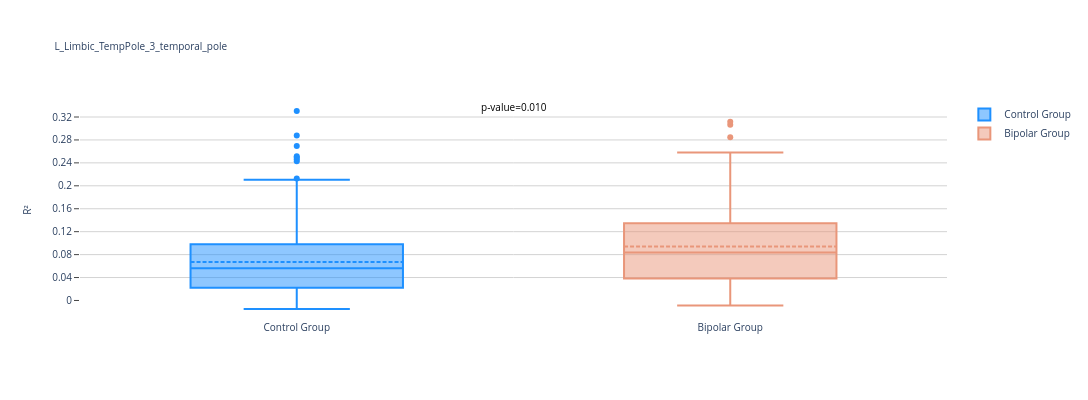

In [296]:
import plotly.graph_objects as go

for region, p in group_main_top_hits.iterrows():
    hc_gp = hc[region]
    bd_gp = bd[region]
    
    hc_gp = replace_ones_with_mean(hc_gp)
    bd_gp = replace_ones_with_mean(bd_gp)

    fig = go.Figure()

    # Add Box plots for Control Group and Bipolar Group
    fig.add_trace(go.Box(y=hc_gp, name='Control Group', marker_color='dodgerblue', boxmean=True))
    fig.add_trace(go.Box(y=bd_gp, name='Bipolar Group', marker_color='darksalmon', boxmean=True))

    fig.update_layout(
        title=dict(
            text=f'{region}',
            font=dict(size=10)  # Change the title font size here
        ),
    yaxis_title=dict(
        text='R²',
        font=dict(size=10)  # Change the y-axis title font size here
        ),
        width=350,  # Set the width of the figure
        height=400,  # Set the height of the figure
        xaxis=dict(mirror=False,
            showline=False,
            tickfont=dict(size=10),
          #  linecolor='grey'
                  ),
        yaxis=dict(
            gridcolor='lightgrey',  # Color of the grid lines
            dtick=0.04,
            mirror=False,
            ticks='outside',
            showline=False,
          #  linecolor='grey',
            gridwidth=1,
            tickfont=dict(size=10)
        ),  # Set the tick distance to add more grid lines
        legend=dict(
            font=dict(size=10)  # Change the legend font size here
        ),
        annotations=[
            dict(
                xref='paper',
                yref='paper',
                x=0.5,
                y=1.01,
                text=f"p-value={p['bonf_p-value']:.3f}",
                showarrow=False,
                font=dict(size=10, color='black'))],
        plot_bgcolor='white',  # Set plot background color to white
        paper_bgcolor='white' )

    fig.show()
    #fig.write_image(f"{region}.svg")

In [247]:
# for 3D viwer

values = []
labels_list = []
for region, p in main_top_hits.iterrows():
    values.append(label_coord[region])
    labels_list.append(region)


    # Fetch the fsaverage dataset for plotting
fsaverage = fetch_surf_fsaverage()
if len(labels_list) > 0:
    view = plotting.view_markers(values, marker_size=10, marker_labels=labels_list)
#view = plotting.view_markers(coords, colors_hex, marker_size=6, title = 'Regional SC-FC Coupling')#marker_labels=list(data_mean.index)

# Display the plot in an interactive window
    #view.open_in_browser()

## Strength & Degree Analyses

In [248]:
strength_degree_path = path + folder + '/results/strength_degree/'

### Structural Degree and Strength ###
hc_degree_sc = pd.read_csv(strength_degree_path + 'hc_degree_fbc.csv')
bd_degree_sc = pd.read_csv(strength_degree_path + 'bd_degree_fbc.csv')
hc_degree_sc.columns = leb['regions'].tolist()
bd_degree_sc.columns = leb['regions'].tolist()
hc_strength_sc = pd.read_csv(strength_degree_path + 'hc_strength_fbc.csv')
bd_strength_sc = pd.read_csv(strength_degree_path + 'bd_strength_fbc.csv')
hc_strength_sc.columns = leb['regions'].tolist()
bd_strength_sc.columns = leb['regions'].tolist()

### Functional (C) Degree and Strength ###
hc_degree_fc = pd.read_csv(strength_degree_path + 'hc_degree_fc.csv')
bd_degree_fc = pd.read_csv(strength_degree_path + 'bd_degree_fc.csv')
hc_degree_fc.columns = leb['regions'].tolist()
bd_degree_fc.columns = leb['regions'].tolist()
hc_strength_fc = pd.read_csv(strength_degree_path + 'hc_strength_fc.csv')
bd_strength_fc = pd.read_csv(strength_degree_path + 'bd_strength_fc.csv')
hc_strength_fc.columns = leb['regions'].tolist()
bd_strength_fc.columns = leb['regions'].tolist()

### Functional (pC) Degree and Strength ###
hc_degree_pfc = pd.read_csv(strength_degree_path + 'hc_degree_pfc.csv')

bd_degree_pfc = pd.read_csv(strength_degree_path + 'bd_degree_pfc.csv')
hc_degree_pfc.columns = leb['regions'].tolist()
bd_degree_pfc.columns = leb['regions'].tolist()
hc_strength_pfc = pd.read_csv(strength_degree_path + 'hc_strength_pfc.csv')
bd_strength_pfc = pd.read_csv(strength_degree_path + 'bd_strength_pfc.csv')
hc_strength_pfc.columns = leb['regions'].tolist()
bd_strength_pfc.columns = leb['regions'].tolist()

hc_degree_sc.index = hc_degree_sc.index.astype('int64') 
bd_degree_sc.index = bd_degree_sc.index.astype('int64') 
hc_degree_fc.index = hc_degree_fc.index.astype('int64') 
bd_degree_fc.index = bd_degree_fc.index.astype('int64') 
hc_degree_pfc.index = hc_degree_pfc.index.astype('int64') 
bd_degree_pfc.index = bd_degree_pfc.index.astype('int64') 

hc_strength_sc.index = hc_strength_sc.index.astype('int64') 
bd_strength_sc.index = bd_strength_sc.index.astype('int64') 
hc_strength_fc.index = hc_strength_fc.index.astype('int64') 
bd_strength_fc.index = bd_strength_fc.index.astype('int64') 
hc_strength_pfc.index = hc_strength_pfc.index.astype('int64') 
bd_strength_pfc.index = bd_strength_pfc.index.astype('int64') 
hc_cov.index = hc_cov.index.astype('int64') 
bd_cov.index = bd_cov.index.astype('int64') 

hc_sd= pd.concat([hc_cov, hc_degree_sc], axis=1)
bd_sd= pd.concat([bd_cov, bd_degree_sc], axis=1)
hc_fd= pd.concat([hc_cov, hc_degree_fc], axis=1)
bd_fd= pd.concat([bd_cov, bd_degree_fc], axis=1)
hc_pfd= pd.concat([hc_cov, hc_degree_pfc], axis=1)
bd_pfd= pd.concat([bd_cov, bd_degree_pfc], axis=1)
hc_sd.set_index('eid', inplace=True)
bd_sd.set_index('eid', inplace=True)
hc_fd.set_index('eid', inplace=True)
bd_fd.set_index('eid', inplace=True)
hc_pfd.set_index('eid', inplace=True)
bd_pfd.set_index('eid', inplace=True)

hc_ss= pd.concat([hc_cov, hc_strength_sc], axis=1)
bd_ss= pd.concat([bd_cov, bd_strength_sc], axis=1)
hc_fs= pd.concat([hc_cov, hc_strength_fc], axis=1)
bd_fs= pd.concat([bd_cov, bd_strength_fc], axis=1)
hc_pfs= pd.concat([hc_cov, hc_strength_pfc], axis=1)
bd_pfs= pd.concat([bd_cov, bd_strength_pfc], axis=1)
hc_ss.set_index('eid', inplace=True)
bd_ss.set_index('eid', inplace=True)
hc_fs.set_index('eid', inplace=True)
bd_fs.set_index('eid', inplace=True)
hc_pfs.set_index('eid', inplace=True)
bd_pfs.set_index('eid', inplace=True)

# this variable is without covars
hc_sd_nocovar = hc_sd.drop(['age', 'sex','centre','gr'], axis=1)
bd_sd_nocovar = bd_sd.drop(['age', 'sex','centre','gr'], axis=1)
hc_fd_nocovar = hc_fd.drop(['age', 'sex','centre','gr'], axis=1)
bd_fd_nocovar = bd_fd.drop(['age', 'sex','centre','gr'], axis=1)
hc_pfd_nocovar = hc_pfd.drop(['age', 'sex','centre','gr'], axis=1)
bd_pfd_nocovar = bd_pfd.drop(['age', 'sex','centre','gr'], axis=1)

hc_ss_nocovar = hc_ss.drop(['age', 'sex','centre','gr'], axis=1)
bd_ss_nocovar = bd_ss.drop(['age', 'sex','centre','gr'], axis=1)
hc_fs_nocovar = hc_fs.drop(['age', 'sex','centre','gr'], axis=1)
bd_fs_nocovar = bd_fs.drop(['age', 'sex','centre','gr'], axis=1)
hc_pfs_nocovar = hc_pfs.drop(['age', 'sex','centre','gr'], axis=1)
bd_pfs_nocovar = bd_pfs.drop(['age', 'sex','centre','gr'], axis=1)

degree_sc = pd.concat([hc_sd, bd_sd], axis=0)
degree_fc = pd.concat([hc_fd, bd_fd], axis=0)
degree_pfc = pd.concat([hc_pfd, bd_pfd], axis=0)

strength_sc = pd.concat([hc_ss, bd_ss], axis=0)
strength_fc = pd.concat([hc_fs, bd_fs], axis=0)
strength_pfc = pd.concat([hc_pfs, bd_pfs], axis=0)

sc_degree_mean = degree_sc.iloc[:,4:].mean()
fc_degree_mean = degree_fc.iloc[:,4:].mean()
pfc_degree_mean = degree_pfc.iloc[:,4:].mean()

sc_strength_mean = strength_sc.iloc[:,4:].mean()
fc_strength_mean = strength_fc.iloc[:,4:].mean()
pfc_strength_mean = strength_pfc.iloc[:,4:].mean()

### Correlation between coupling R^2 and degree/strength

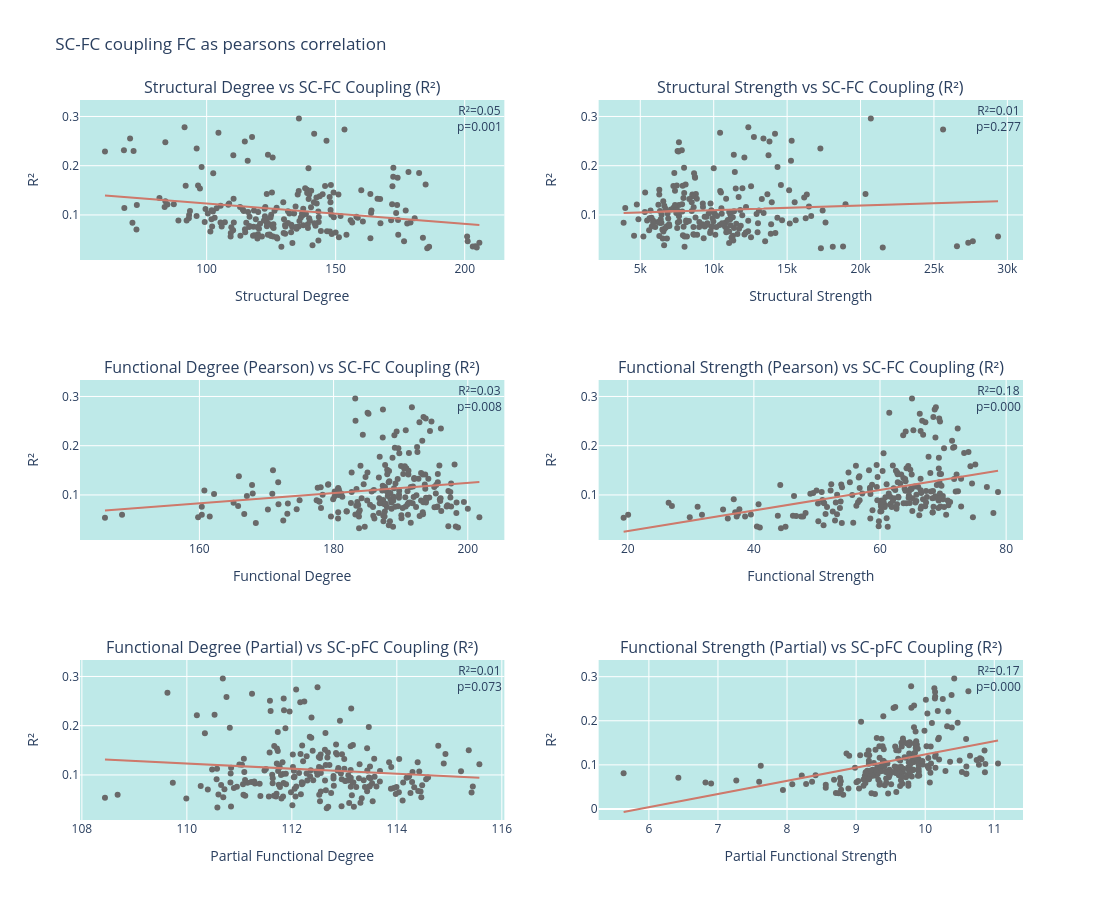

In [249]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import linregress

# Create a 3x2 subplot figure
fig = make_subplots(rows=3, cols=2, subplot_titles=(
    'Structural Degree vs SC-FC Coupling (R²)',
    'Structural Strength vs SC-FC Coupling (R²)',
    'Functional Degree (Pearson) vs SC-FC Coupling (R²)',
    'Functional Strength (Pearson) vs SC-FC Coupling (R²)',
    'Functional Degree (Partial) vs SC-pFC Coupling (R²)', #makre sure to load pFC for this
    'Functional Strength (Partial) vs SC-pFC Coupling (R²)'  #makre sure to load pFC for this
))

# Define the data sets
data_sets = [
    (sc_degree_mean, 'Structural Degree', 'R²', 1, 1),
    (sc_strength_mean, 'Structural Strength', 'R²', 1, 2),
    (fc_degree_mean, 'Functional Degree', 'R²', 2, 1),
    (fc_strength_mean, 'Functional Strength', 'R²', 2, 2),
    (pfc_degree_mean, 'Partial Functional Degree', 'R²', 3, 1),
    (pfc_strength_mean, 'Partial Functional Strength', 'R²', 3, 2)
]

# Loop through each data set and create the scatter and regression line plots
for datas, x_title, y_title, row, col in data_sets:
    slope, intercept, r_value, p_value, std_err = linregress(datas, data_mean)
    regression_line = slope * datas + intercept
    
    # Add scatter plot with grey markers
    fig.add_trace(go.Scatter(x=datas, y=data_mean, mode='markers', marker=dict(color='dimgrey'), name='', showlegend=False), row=row, col=col)
    
    # Add regression line
    fig.add_trace(go.Scatter(x=datas, y=regression_line, mode='lines', 
                             name=f'Regression line', 
                             line=dict(color='rgb(206, 121, 107)'), showlegend=False), row=row, col=col)
    
    # Add annotation for R² and p-value
    fig.add_annotation(
        xref=f"x{col if row == 1 else col + (row-1)*2}",
        yref=f"y{col if row == 1 else col + (row-1)*2}",
        x=max(datas),
        y=max(data_mean),
        text=f"R²={r_value**2:.2f}<br>p={p_value:.3f}",
        showarrow=False
    )
    
    # Update axis titles
    fig.update_xaxes(title_text=x_title, row=row, col=col)
    fig.update_yaxes(title_text=y_title, row=row, col=col)

fig.update_layout(height=900, width=1100, title_text="SC-FC coupling FC as pearsons correlation", 
                  plot_bgcolor='rgb(190, 233, 232)', paper_bgcolor='white')

fig.show()
fig.write_image(f"degree_strength_{files}_{analysis}_{folder}.svg")

adjust p-value to bonf for 3 tests

structural degree has a negative relationship with coupling, meaing, regions with more structural connections apear to have lower relationship between anatomy and neural communication. This could be explained as regions with more axonal extentions would be more poly-synaptic and have more flexible indirect communication with regions beyond their direct connections.

functional strength has a positive relationship with coupling. this means that regions that are more constrained by their anatomy will also ccommunicate with more regions (degree is also positive). The anatomical backbone might support neural communication.

need to compare with the Gu paper

for specific region:

In [250]:
for region ,p in main_top_hits.iterrows():
    correlation = degree_sc.loc[:,region].corr(clean_data.loc[:,region])
    print(f'the correlation in {region} is {correlation} (structural degree)')

the correlation in L_Limbic_TempPole_3_temporal_pole is -0.03737057258917423 (structural degree)


In [251]:
for region ,p in main_top_hits.iterrows():
    correlation = strength_fc.loc[:,region].corr(clean_data.loc[:,region])
    print(f'the correlation in {region} is {correlation} functional strength')

the correlation in L_Limbic_TempPole_3_temporal_pole is -0.19028830262221175 functional strength


In [252]:
data_mean_max = sc_strength_mean.sort_values(ascending=False)
data_mean_min = sc_strength_mean.sort_values()
print('Highest structural strength regions')
print(data_mean_max.head(5),'\n')
print('Lowest structural strength regions')
print(data_mean_min.head(5),'\n')

data_mean_max = sc_degree_mean.sort_values(ascending=False)
data_mean_min = sc_degree_mean.sort_values()
print('Highest structural degree regions')
print(data_mean_max.head(5),'\n')
print('Lowest structural degree regions')
print(data_mean_min.head(5), '\n')

Highest structural strength regions
L_putamen                 29364.092821
R_putamen                 27648.112078
L_anterior_thalamus       27334.795545
R_anterior_thalamus       26565.913099
L_Vis_13_cuneal_cortex    25621.923187
dtype: float64 

Lowest structural strength regions
R_SomMot_8_posterior_cingulate_gyrus             3864.286872
L_Default_pCunPCC_3_posterior_cingulate_gyrus    3977.514713
R_Cont_PFCv_1_insular_cortex                     4574.962476
L_Vis_6_lingual_gyrus                            4762.777300
R_Default_PFCdPFCm_3_anterior_cingulate_gyrus    4873.322638
dtype: float64 

Highest structural degree regions
L_anterior_thalamus     205.691207
L_posterior_thalamus    204.666667
R_anterior_thalamus     204.161554
R_posterior_thalamus    203.126789
R_putamen               201.153374
dtype: float64 

Lowest structural degree regions
R_Vis_4_lingual_gyrus                            60.597137
L_Vis_4_lingual_gyrus                            67.944785
L_Default_pCunPCC_

In [253]:
data_mean_max = fc_strength_mean.sort_values(ascending=False)
data_mean_min = fc_strength_mean.sort_values()
print('Highest functional strength regions')
print(data_mean_max.head(5),'\n')
print('Lowest functional strength regions')
print(data_mean_min.head(5),'\n')

data_mean_max = fc_degree_mean.sort_values(ascending=False)
data_mean_min = fc_degree_mean.sort_values()
print('Highest functional degree regions')
print(data_mean_max.head(5),'\n')
print('Lowest functional degree regions')
print(data_mean_min.head(5), '\n')

Highest functional strength regions
R_DorsAttn_Post_2_middle_temporooccipital_gyrus        78.715451
R_DorsAttn_Post_1_inferior_temporooccipital_gyrus      77.979631
L_Vis_8_lateral_inferior_occipital_cortex              76.945900
L_DorsAttn_Post_9_precunous_cortex                     75.110602
L_DorsAttn_Post_1_temporal_occipital_fusiform_gyrus    74.732375
dtype: float64 

Lowest functional strength regions
R_pallidum     19.342940
L_pallidum     20.059391
L_accumbens    26.481744
R_accumbens    27.000466
R_amygdala     29.829931
dtype: float64 

Highest functional degree regions
L_DorsAttn_Post_1_temporal_occipital_fusiform_gyrus    201.728016
R_SomMot_1_heschls_gyrus                               200.008180
L_SomMot_2_planum_temporale                            199.421268
L_posterior_thalamus                                   198.546012
L_SomMot_3_insular_cortex                              198.325153
dtype: float64 

Lowest functional degree regions
R_pallidum                     

In [254]:
data_mean_max = pfc_strength_mean.sort_values(ascending=False)
data_mean_min = pfc_strength_mean.sort_values()
print('Highest partial functional strength regions')
print(data_mean_max.head(5),'\n')
print('Lowest partial functional strength regions')
print(data_mean_min.head(5),'\n')

data_mean_max = fc_degree_mean.sort_values(ascending=False)
data_mean_min = fc_degree_mean.sort_values()
print('Highest functional degree regions')
print(data_mean_max.head(5),'\n')
print('Lowest functional degree regions')
print(data_mean_min.head(5), '\n')

Highest partial functional strength regions
R_Default_Par_3_superior_lateral_occipital_cortex    11.054220
L_Default_Par_4_superior_lateral_occipital_cortex    10.870667
R_Default_Par_1_superior_lateral_occipital_cortex    10.864489
L_Cont_pCun_1_precuneous_cortex                      10.858764
R_Cont_Par_1_posterior_supramarginal_gyrus           10.814887
dtype: float64 

Lowest partial functional strength regions
L_Limbic_OFC_2_frontal_medial_cortex                     5.634337
R_Limbic_OFC_1_frontal_pole                              6.426563
L_Limbic_TempPole_2_posterior_inferior_temporal_gyrus    6.819284
R_Limbic_TempPole_2_posterior_inferior_temporal_gyrus    6.900675
L_Limbic_TempPole_1_anterior_temporal_fusiform_cortex    7.265354
dtype: float64 

Highest functional degree regions
L_DorsAttn_Post_1_temporal_occipital_fusiform_gyrus    201.728016
R_SomMot_1_heschls_gyrus                               200.008180
L_SomMot_2_planum_temporale                            199.421268
L_

# ANCOVA for structural degree (1st) and strength (2nd)

In [255]:
model_summaries = []  # store model summaries
group_p_values = []  # store p-values for 'group'
group_f_values =[]
# Perform ANCOVA for each outcome variable column separately
for col in degree_sc.columns[4:]:  # outcome variable columns start from index 4
    # Remove outliers for the current column
    y = degree_sc[col].copy()
    yr = replace_outliers(y, 'z')
    # Standardize the cleaned column
#    y_standardized = scaler.fit_transform(yr.values.reshape(-1, 1))#.reshape(-1, 1)
#    y_standardized = pd.Series(y_standardized.flatten(), index=yr.index)
    # Concatenate cleaned y with independent variables
    temp_data = pd.concat([yr, degree_sc[['gr', 'age', 'sex', 'centre']]], axis=1)
    temp_data.dropna(inplace=True)
    temp_data.columns = [col, 'gr', 'age', 'sex', 'centre']
    
    # Perform ANCOVA
    formula = f'{col} ~ C(gr) + age + C(sex) + C(centre)'  # ANCOVA formula with concatenated data
    model = ols(formula, data=temp_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    model_summaries.append(anova_table)
    group_p_values.append(anova_table.loc['C(gr)', 'PR(>F)'])  # extract p-value for 'group'
    group_f_values.append(anova_table.loc['C(gr)', 'F'])

# Apply FDR correction to the p-values for 'group'
_, fdr_corrected_p_values, _, _ = multipletests(group_p_values, method='fdr_bh')
fdr_corrected_p_values_df = pd.DataFrame(fdr_corrected_p_values, index=degree_sc.columns[4:], columns=['FDR p-value'])
f_values_df = pd.DataFrame(group_f_values, index=degree_sc.columns[4:], columns=['F-value'])
p_values_df = pd.DataFrame(group_p_values, index=degree_sc.columns[4:], columns=['p-value'])
result_df = pd.concat([f_values_df, fdr_corrected_p_values_df, p_values_df], axis=1)

top_hits=result_df.sort_values(by='FDR p-value')
top_hits.head(15)
# Print summary of each model and FDR corrected p-values for 'group'
#for idx, summary in enumerate(model_summaries):
#    print(f"ANCOVA Summary for Outcome Variable {data.columns[4:][idx]}:")
#    print(summary)
#    print(f"FDR corrected p-value for 'group': {fdr_corrected_p_values[idx]}")

NameError: name 'replace_outliers' is not defined

In [ ]:
scaler = StandardScaler()
model_summaries = []  # store model summaries
group_p_values = []  # store p-values for 'group'
group_f_values =[]
# Perform ANCOVA for each outcome variable column separately
for col in strength_sc.columns[4:]:  # outcome variable columns start from index 4
    # Remove outliers for the current column
    y = strength_sc[col].copy()
    yr = replace_outliers(y, 'z')
    # Standardize the cleaned column
#    y_standardized = scaler.fit_transform(yr.values.reshape(-1, 1))#.reshape(-1, 1)
#    y_standardized = pd.Series(y_standardized.flatten(), index=yr.index)
  #  print(y_standardized.shape)
    # Concatenate cleaned y with independent variables
    temp_data = pd.concat([yr, strength_sc[['gr', 'age', 'sex', 'centre']]], axis=1)
    temp_data.dropna(inplace=True)
    temp_data.columns = [col, 'gr', 'age', 'sex', 'centre']
    # Perform ANCOVA
    formula = f'{col} ~ C(gr) + age + C(sex) + C(centre)'  # ANCOVA formula with concatenated data
    model = ols(formula, data=temp_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    model_summaries.append(anova_table)
    group_p_values.append(anova_table.loc['C(gr)', 'PR(>F)'])  # extract p-value for 'group'
    group_f_values.append(anova_table.loc['C(gr)', 'F'])

# Apply FDR correction to the p-values for 'group'
_, fdr_corrected_p_values, _, _ = multipletests(group_p_values, method='fdr_bh')
fdr_corrected_p_values_df = pd.DataFrame(fdr_corrected_p_values, index=strength_sc.columns[4:], columns=['FDR p-value'])
f_values_df = pd.DataFrame(group_f_values, index=strength_sc.columns[4:], columns=['F-value'])
p_values_df = pd.DataFrame(group_p_values, index=strength_sc.columns[4:], columns=['p-value'])
result_df = pd.concat([f_values_df, fdr_corrected_p_values_df, p_values_df], axis=1)

top_hits=result_df.sort_values(by='FDR p-value')
top_hits.head(5)
# Print summary of each model and FDR corrected p-values for 'group'
#for idx, summary in enumerate(model_summaries):
#    print(f"ANCOVA Summary for Outcome Variable {data.columns[4:][idx]}:")
#    print(summary)
#    print(f"FDR corrected p-value for 'group': {fdr_corrected_p_values[idx]}")


# ANCOVA for functional degree (1st) and strength (2nd)

In [ ]:
scaler = StandardScaler()
model_summaries = []  # store model summaries
group_p_values = []  # store p-values for 'group'
group_f_values =[]
# Perform ANCOVA for each outcome variable column separately
for col in degree_fc.columns[4:]:  # outcome variable columns start from index 4
    # Remove outliers for the current column
    y = degree_fc[col].copy()
    yr = replace_outliers(y, 'z')
    # Standardize the cleaned column
#    y_standardized = scaler.fit_transform(yr.values.reshape(-1, 1))#.reshape(-1, 1)
#    y_standardized = pd.Series(y_standardized.flatten(), index=yr.index)
  #  print(y_standardized.shape)
    # Concatenate cleaned y with independent variables
    temp_data = pd.concat([yr, degree_fc[['gr', 'age', 'sex', 'centre']]], axis=1)
    temp_data.columns = [col, 'gr', 'age', 'sex', 'centre']
    temp_data.dropna(inplace=True)
    # Perform ANCOVA
    formula = f'{col} ~ C(gr) + age + C(sex) + C(centre)'  # ANCOVA formula with concatenated data
    model = ols(formula, data=temp_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    model_summaries.append(anova_table)
    group_p_values.append(anova_table.loc['C(gr)', 'PR(>F)'])  # extract p-value for 'group'
    group_f_values.append(anova_table.loc['C(gr)', 'F'])

# Apply FDR correction to the p-values for 'group'
_, fdr_corrected_p_values, _, _ = multipletests(group_p_values, method='fdr_bh')
fdr_corrected_p_values_df = pd.DataFrame(fdr_corrected_p_values, index=degree_fc.columns[4:], columns=['FDR p-value'])
f_values_df = pd.DataFrame(group_f_values, index=degree_fc.columns[4:], columns=['F-value'])
p_values_df = pd.DataFrame(group_p_values, index=degree_fc.columns[4:], columns=['p-value'])
result_df = pd.concat([f_values_df, fdr_corrected_p_values_df, p_values_df], axis=1)

top_hits=result_df.sort_values(by='FDR p-value')
top_hits.head(5)
# Print summary of each model and FDR corrected p-values for 'group'
#for idx, summary in enumerate(model_summaries):
#    print(f"ANCOVA Summary for Outcome Variable {data.columns[4:][idx]}:")
#    print(summary)
#    print(f"FDR corrected p-value for 'group': {fdr_corrected_p_values[idx]}")

In [ ]:
scaler = StandardScaler()
model_summaries = []  # store model summaries
group_p_values = []  # store p-values for 'group'
group_f_values =[]
# Perform ANCOVA for each outcome variable column separately
for col in strength_fc.columns[4:]:  # outcome variable columns start from index 4
    # Remove outliers for the current column
    y = strength_fc[col].copy()
    yr = replace_outliers(y, 'z')
    # Standardize the cleaned column
  #  y_standardized = scaler.fit_transform(yr.values.reshape(-1, 1))#.reshape(-1, 1)
 #   y_standardized = pd.Series(y_standardized.flatten(), index=yr.index)
  #  print(y_standardized.shape)
    # Concatenate cleaned y with independent variables
    temp_data = pd.concat([yr, strength_fc[['gr', 'age', 'sex', 'centre']]], axis=1)
    temp_data.dropna(inplace=True)    
    temp_data.columns = [col, 'gr', 'age', 'sex', 'centre']
    
    # Perform ANCOVA
    formula = f'{col} ~  C(gr) + age + C(sex) + C(centre)'  # ANCOVA formula with concatenated data
    model = ols(formula, data=temp_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    model_summaries.append(anova_table)
    group_p_values.append(anova_table.loc['C(gr)', 'PR(>F)'])  # extract p-value for 'group'
    group_f_values.append(anova_table.loc['C(gr)', 'F'])

# Apply FDR correction to the p-values for 'group'
_, fdr_corrected_p_values, _, _ = multipletests(group_p_values, method='fdr_bh')
fdr_corrected_p_values_df = pd.DataFrame(fdr_corrected_p_values, index=strength_fc.columns[4:], columns=['FDR p-value'])
f_values_df = pd.DataFrame(group_f_values, index=strength_fc.columns[4:], columns=['F-value'])
p_values_df = pd.DataFrame(group_p_values, index=strength_fc.columns[4:], columns=['p-value'])
result_df = pd.concat([f_values_df, fdr_corrected_p_values_df, p_values_df], axis=1)

top_hits=result_df.sort_values(by='FDR p-value')
top_hits.head(5)
# Print summary of each model and FDR corrected p-values for 'group'
#for idx, summary in enumerate(model_summaries):
#    print(f"ANCOVA Summary for Outcome Variable {data.columns[4:][idx]}:")
#    print(summary)
#    print(f"FDR corrected p-value for 'group': {fdr_corrected_p_values[idx]}")

# ANCOVA for partial functional degree (1st) and strength (2nd)

In [ ]:
scaler = StandardScaler()
model_summaries = []  # store model summaries
group_p_values = []  # store p-values for 'group'
group_f_values =[]
# Perform ANCOVA for each outcome variable column separately
for col in degree_pfc.columns[4:]:  # outcome variable columns start from index 4
    # Remove outliers for the current column
    y = degree_pfc[col].copy()
    yr = replace_outliers(y, 'z')
    # Standardize the cleaned column
#    y_standardized = scaler.fit_transform(yr.values.reshape(-1, 1))#.reshape(-1, 1)
#    y_standardized = pd.Series(y_standardized.flatten(), index=yr.index)
  #  print(y_standardized.shape)
    # Concatenate cleaned y with independent variables
    temp_data = pd.concat([yr, degree_pfc[['gr', 'age', 'sex', 'centre']]], axis=1)
    temp_data.dropna(inplace=True)    
    temp_data.columns = [col, 'gr', 'age', 'sex', 'centre']
    
    # Perform ANCOVA
    formula = f'{col} ~ C(gr) + age + C(sex) + C(centre)'  # ANCOVA formula with concatenated data
    model = ols(formula, data=temp_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    model_summaries.append(anova_table)
    group_p_values.append(anova_table.loc['C(gr)', 'PR(>F)'])  # extract p-value for 'group'
    group_f_values.append(anova_table.loc['C(gr)', 'F'])

# Apply FDR correction to the p-values for 'group'
_, fdr_corrected_p_values, _, _ = multipletests(group_p_values, method='fdr_bh')
fdr_corrected_p_values_df = pd.DataFrame(fdr_corrected_p_values, index=degree_pfc.columns[4:], columns=['FDR p-value'])
f_values_df = pd.DataFrame(group_f_values, index=degree_pfc.columns[4:], columns=['F-value'])
p_values_df = pd.DataFrame(group_p_values, index=degree_pfc.columns[4:], columns=['p-value'])
result_df = pd.concat([f_values_df, fdr_corrected_p_values_df, p_values_df], axis=1)


top_hits=result_df.sort_values(by='FDR p-value')
top_hits.head(5)
# Print summary of each model and FDR corrected p-values for 'group'
#for idx, summary in enumerate(model_summaries):
#    print(f"ANCOVA Summary for Outcome Variable {data.columns[4:][idx]}:")
#    print(summary)
#    print(f"FDR corrected p-value for 'group': {fdr_corrected_p_values[idx]}")


In [ ]:
scaler = StandardScaler()
model_summaries = []  # store model summaries
group_p_values = []  # store p-values for 'group'
group_f_values =[]
# Perform ANCOVA for each outcome variable column separately
for col in strength_pfc.columns[4:]:  # outcome variable columns start from index 4
    # Remove outliers for the current column
    y = strength_pfc[col].copy()
    yr = replace_outliers(y, 'z')
    # Standardize the cleaned column
    y_standardized = scaler.fit_transform(yr.values.reshape(-1, 1))#.reshape(-1, 1)
    y_standardized = pd.Series(y_standardized.flatten(), index=yr.index)
  #  print(y_standardized.shape)
    # Concatenate cleaned y with independent variables
    temp_data = pd.concat([y_standardized, strength_pfc[['gr', 'age', 'sex', 'centre']]], axis=1)
    temp_data.dropna(inplace=True)
    temp_data.columns = [col, 'gr', 'age', 'sex', 'centre']
    
    # Perform ANCOVA
    formula = f'{col} ~ C(gr) + age + C(sex) + C(centre)'  # ANCOVA formula with concatenated data
    model = ols(formula, data=temp_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    model_summaries.append(anova_table)
    group_p_values.append(anova_table.loc['C(gr)', 'PR(>F)'])  # extract p-value for 'group'
    group_f_values.append(anova_table.loc['C(gr)', 'F'])

# Apply FDR correction to the p-values for 'group'
_, fdr_corrected_p_values, _, _ = multipletests(group_p_values, method='fdr_bh')
fdr_corrected_p_values_df = pd.DataFrame(fdr_corrected_p_values, index=strength_pfc.columns[4:], columns=['FDR p-value'])
f_values_df = pd.DataFrame(group_f_values, index=strength_pfc.columns[4:], columns=['F-value'])
p_values_df = pd.DataFrame(group_p_values, index=strength_pfc.columns[4:], columns=['p-value'])
result_df = pd.concat([f_values_df, fdr_corrected_p_values_df, p_values_df], axis=1)

top_hits=result_df.sort_values(by='FDR p-value')
top_hits.head(5)
# Print summary of each model and FDR corrected p-values for 'group'
#for idx, summary in enumerate(model_summaries):
#    print(f"ANCOVA Summary for Outcome Variable {data.columns[4:][idx]}:")
#    print(summary)
#    print(f"FDR corrected p-value for 'group': {fdr_corrected_p_values[idx]}")